In [1]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import pickle
import glob

<br> 이번에는 익절/손절라인을 결정할 수 있는 예측모델을 만들어 보겠습니다. 먼저 피쳐가 있는 데이터를 불러옵니다. 

In [43]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


<br> 날짜와 종목을 인덱스로 설정합니다. 데이터에 예측모델을 적용하고 매수 대상 종목을 select_top 이라는 DataFrame 에 저장합니다. 

In [44]:
mdl_all = feature_all.set_index([feature_all.index,'code'])

with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = mdl_all[feature_list]
y = mdl_all['target']

yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

mdl_all['yhat'] = yhat

tops = mdl_all[mdl_all['yhat'] > 0.3].copy()

tops['return_rank']  = pd.qcut(tops['return'], q=3, labels=range(3)) # 종가 수익률
tops['price_rank']  = pd.qcut(tops['price_z'], q=3, labels=range(3)) # 가격 변동성

select_tops = tops[(tops['return_rank']==2) & (tops['price_rank']==0)]

<br> 최저 기대 수익율과 피쳐와의 상관계수를 조사합니다. 예상하지 못햇던 사실은 5 영업일 동안 최저 기대 수익률은 종목보다는 지수 수익률과 더 상관관계가 높습니다. 

In [45]:
select_tops[['return','kosdaq_return','min_close']].corr()

,return,kosdaq_return,min_close
return,1.000000,0.181246,-0.004027
kosdaq_return,0.181246,1.000000,0.194672
min_close,-0.004027,0.194672,1.000000


<br> 두 개의 피쳐 - 'return' 와 'kosdaq_return' 이용해서 단순한 예측모델을 구현합니다. 머신러닝 모델 중 가장 쉽게 접근할 수 있는 랜덤포레스트 회귀모형에 쉽게 빌드해 봅니다. 그래프를 보니 예측값이 기대 최저 수익률을 잘 따라가는 것으로 보입니다. 

In [47]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=4, min_samples_leaf=30) # 정해진 하이퍼파라미터를 가진 객체를 생성

X = select_tops[['return', 'kosdaq_return']]
y = select_tops['min_close']

rf.fit(X, y)
yhat = rf.predict(X) # 최저 기대수익율 예측
yhat = pd.Series(yhat, name='min_yhat', index=y.index) 

min_yhat
(0.913, 0.954]    0.938265
(0.954, 0.981]    0.967607
(0.981, 1.03]     1.005554
Name: min_close, dtype: float64


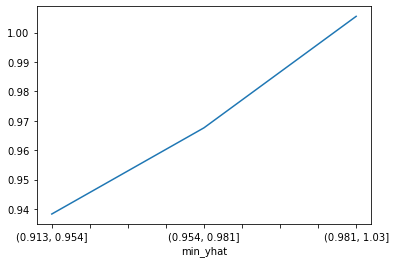

In [59]:
def perf(y, yhat): # 20 Percentile 분석
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['min_yhat'], q=3)
    print(combined.groupby(ranks)['min_close'].mean())
    combined.groupby(ranks)['min_close'].mean().plot()

perf(y, yhat)

<br> 만들어진 모델을 pickle 파일로 저장하고, 최소 기대 수익률에 손절라인을 반환하는 함수를 만듭니다.

In [60]:
import pickle
with open("rf.pkl", "wb") as file:
    pickle.dump(rf, file)    
    
with open("rf.pkl", "rb") as file:
    rf = pickle.load(file)     

<br> 위 최소 기대 수익률 값에 따라 아래와 같이 익절/손절 라인을 변동할 수 있도록 합니다. 아래 함수는 익절 수익률과 손절 수익률을 딕셔너리로 반환합니다.

In [42]:
def profit_loss_cut(x):
    
    if x <= 0.95: # 익절 손절 범위 축소
        return {1.04, 0.98} 
    
    elif x <= 0.98: 
        return {1.05, 0.97}
    
    else: # 익절/손절범위 확대
        return {1.06, 0.96}